In [110]:
import torch
import torch.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys

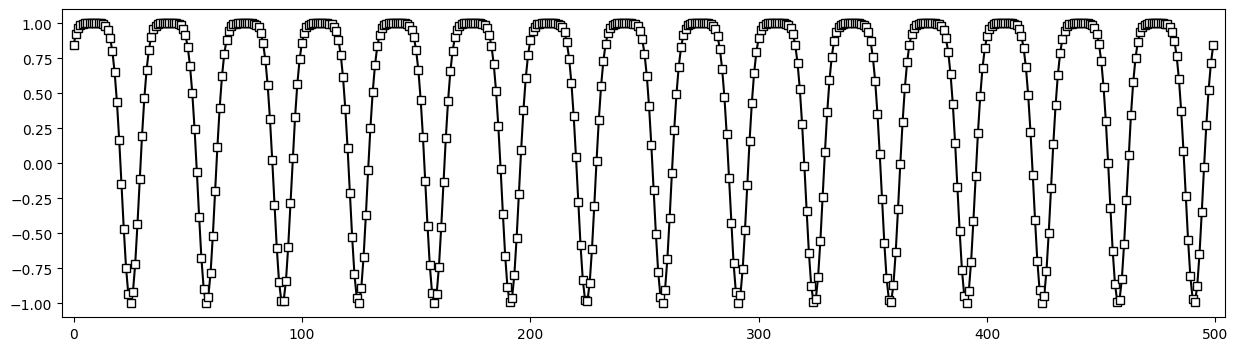

In [111]:
# Create the data
N = 500

time = torch.linspace(0, 30*torch.pi, N)
data = torch.sin(time + torch.cos(time))

plt.figure(figsize=(15,4))
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-5, N+4])
plt.show()

In [112]:
# Create the Deep Learning Model
def createTheNet(printtoggle, input_size, num_hidden, num_layers, bias, batchsize):
    class lstmClassNet(nn.Module):
        def __init__(self, input_size, num_hidden, num_layers, bias, batchsize):
            
            super().__init__()
            self.printT = printtoggle
            
            # Store Parameters
            self.input_size = input_size
            self.num_hidden = num_hidden
            self.num_layers = num_layers
            self.bias = bias
            self.batchsize = batchsize
            
            # # # ----- RNN layers ------ # # #
            # nn.RNN(input_size, num_hidden)
            self.lstm = nn.LSTM(input_size, num_hidden,  num_layers,
                              bias=self.bias)
            
            # # # ----- linear layer ------ # # #
            self.out = nn.Linear(num_hidden, 1)
            
        def forward(self,x,h):
            
            # removed init of hidden for rnn
            # hidden = torch.zeros(self.num_layers, self.batchsize, self.num_hidden)
            if self.printT: print(f'Input: {list(x.shape)}')
            
            # run through the RNN layer
            # y,hidden = self.rnn(x, hidden)
            y,hidden = self.lstm(x,h)
            if self.printT: print(f'RNN-out: {list(y.shape)}')
            if self.printT: print(f'RNN-Hidden: {list(hidden[0].shape)}')
            if self.printT: print(f'RNN-Cell: {list(hidden[1].shape)}')
            
            # pass the rnn output through linear layer
            o = self.out(y)
            if self.printT: print(f'Output: {list(o.shape)}')
            
            return o, hidden
    
    modelInstance = lstmClassNet(input_size, num_hidden, num_layers, bias, batchsize)

    lossfun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001)
    
    return modelInstance, lossfun, optimizer

In [163]:
# network parameters
input_size = 1  # channels/features of data
num_hidden = 16 # breadth of model (number of hidden layers)
num_layers = 2  # depth of model   (number of stacks of hidden layers)
seqlength  = 100  # num of data points used for learning in each segment 
batchsize  = 1  # number of batches of seqlength
bias = True
#N = 50          # number of data units

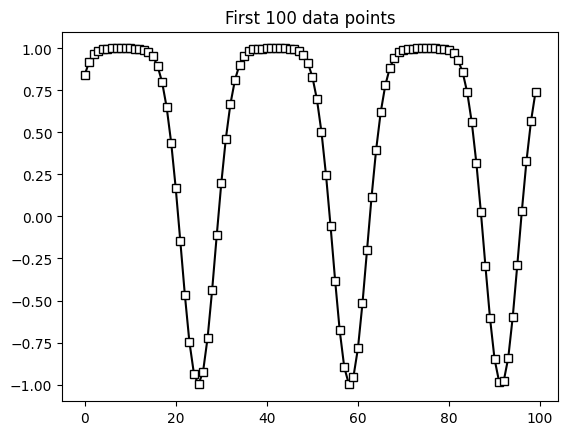

In [164]:
# is seqlength enough data?
plt.plot(data[:seqlength], 'ks-', markerfacecolor='w')
plt.title(f'First {seqlength} data points')
plt.show()

In [115]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True, input_size, num_hidden, num_layers, bias, batchsize)
print(net2)

#check all learnable parameters
for p in net2.named_parameters():
    print(f'{p[0]:>20} has size {list(p[1].shape)}')

lstmClassNet(
  (lstm): LSTM(1, 16, num_layers=2)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
   lstm.weight_ih_l0 has size [64, 1]
   lstm.weight_hh_l0 has size [64, 16]
     lstm.bias_ih_l0 has size [64]
     lstm.bias_hh_l0 has size [64]
   lstm.weight_ih_l1 has size [64, 16]
   lstm.weight_hh_l1 has size [64, 16]
     lstm.bias_ih_l1 has size [64]
     lstm.bias_hh_l1 has size [64]
          out.weight has size [1, 16]
            out.bias has size [1]


In [116]:
# # test the model with some data
# # convert 1d array into tensor
# X = data[:seqlength].view(seqlength, batchsize, input_size)
# num_outputs = 1
# # rnn & lstm: create some data for loss
# y = torch.rand(seqlength, batchsize, num_outputs)
# hidden = (
#     torch.rand(seqlength, batchsize, num_outputs),
#     torch.rand(seqlength, batchsize, num_outputs)
# )
# # rnn & lstm
# yHat,h = net2(X, hidden)
# finalValue = yHat[0][-1]

# # rnn & lstm: create some data
# # X = torch.rand(seqlength, batchsize, input_size)

# # lstm only: create initial hidden states (initialized as zeros)
# # H = torch.zeros(num_layers, batchsize, num_hidden)
# # C = torch.zeros(num_layers, batchsize, num_hidden)

# # lstm only: the input is acutally a tuple of (hidden, cell)
# # hiddenInputs = ((H,C))

# # lstm only: run some data through the model & show the output sizes
# # yHat,h = self.lstm(X, hiddenInputs)
# #h[0] -> hidden
# #h[1] -> cell

# #grab final predicted value

# # # try a loss function
# lossfun = nn.MSELoss()

# lossfun(finalValue, y)


In [117]:
# checl the learned parameters & their sizes
for p in net2.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')
        # size of weight matrix = w_li + w_if + w_ig + w_io = 4*hidden-size*Input-size

lstm.weight_ih_l0 has size [64, 1]
lstm.weight_hh_l0 has size [64, 16]
lstm.weight_ih_l1 has size [64, 16]
lstm.weight_hh_l1 has size [64, 16]
out.weight has size [1, 16]


In [118]:
# Train the Model
def trainTheModel(trainedModel, lossfun, optimizer, epochs=30):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc    = torch.zeros(numepochs)
    testLoss    = torch.zeros(numepochs)
    testAcc     = torch.zeros(numepochs)

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainSegLoss = []
        trainSegAcc  = []
        hiddenState = (
            torch.zeros(num_layers, batchsize, num_hidden), # hidden state
            torch.zeros(num_layers, batchsize, num_hidden)  # cell state
        )
        #loop over data segments / sequences
        for timei in range(N-seqlength):
            
            # Grab a snippet of data
            X = data[timei:timei+seqlength].view(seqlength, batchsize, input_size)
            y = (data[timei+seqlength]).float().view(batchsize, 1)
            
            # push data to GPU
            # X = X.to(device)
            # y = y.to(device)
            
            #Forward pass & loss
            yHat,hiddenState = trainedModel(X, hiddenState)
            finalValue = yHat[-1]
            loss = lossfun(finalValue, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            hiddenState = (hiddenState[0].detach(), hiddenState[1].detach()) 
            #loss from this batch
            trainSegLoss.append(loss.item())
            
            #accuracy from this batch
        
        #average accuracy across mini-batches        
        
        #average losses across all mini-batches
        trainLoss[epochi] = torch.tensor(trainSegLoss).float().mean()
        
        msg =f'Finished epoch {epochi+1}/{numepochs}'
        sys.stdout.write('\r'+msg)
        
    return trainLoss, trainedModel

In [119]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun2, optimizer2 = createTheNet(False, input_size, num_hidden, num_layers, bias, batchsize)
trainLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

Finished epoch 1/1

In [120]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet(False, input_size, num_hidden, num_layers, bias, batchsize)
trainLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

Finished epoch 30/30

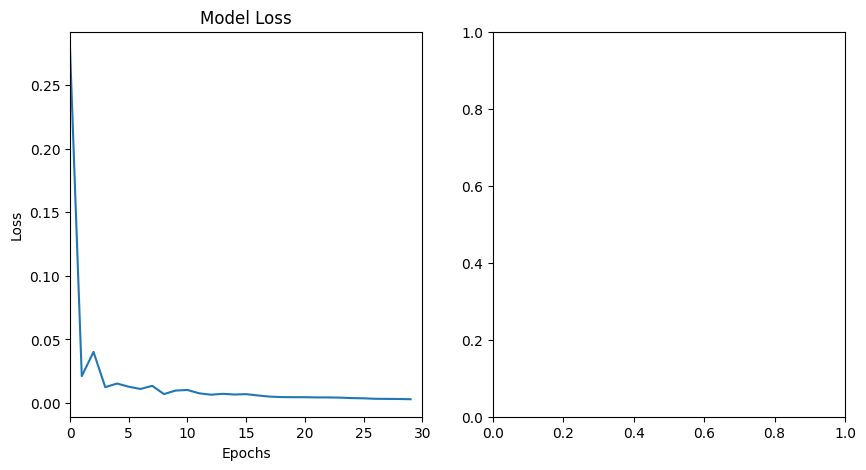

In [121]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlim([0,30])

# ax[1].plot(trainAcc, 'm^-', markerfacecolor='g', markersize=15, label='Train')
# # ax[1].plot(testAcc, label='Test')
# ax[1].legend()
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title(f'Train sign accuracy {trainAcc[-1]:.2f}%')
# ax[1].set_ylim([0,110])
# ax[1].set_xlim([0,30])

plt.show()

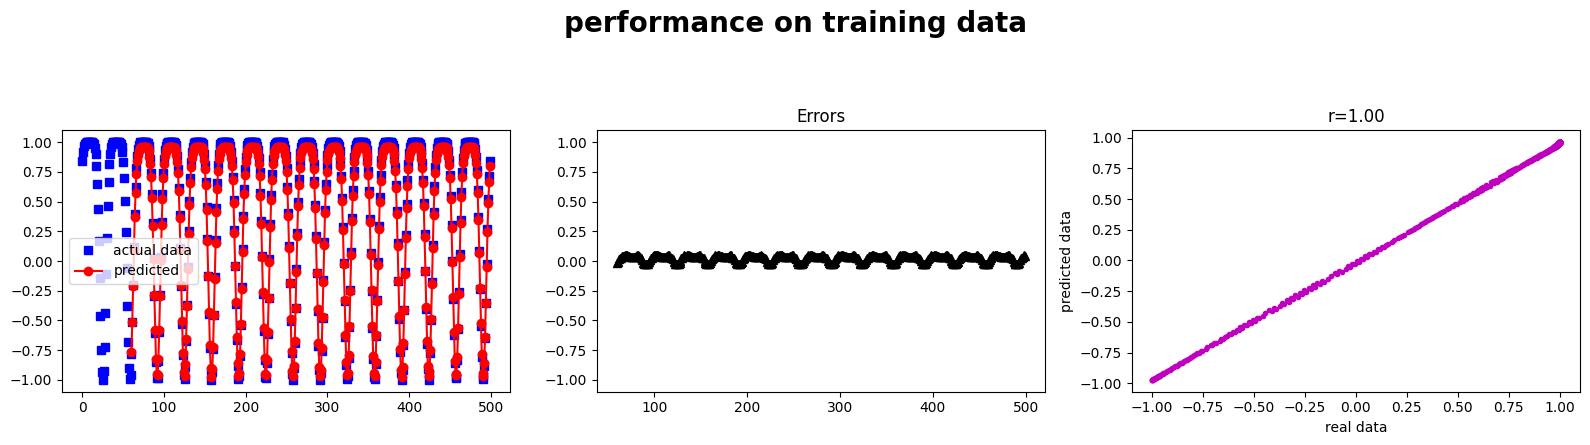

In [152]:
# Test the network

# Initialize hidden state
hiddenState = (
    torch.zeros(num_layers, batchsize, num_hidden), # hidden state
    torch.zeros(num_layers, batchsize, num_hidden)  # cell state
)

# Initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan
h0 = np.zeros((N, num_hidden))
h1 = np.zeros((N, num_hidden))

# Loop over time segments
for timei in range(N-seqlength):
    
    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength, batchsize, input_size)
    
    #forward pass & loss
    yy, hiddenState = trainedModel(X,hiddenState)
    yHat[timei+seqlength] = yy[-1].item()
    hiddenState = (hiddenState[0].detach(), hiddenState[1].detach())

    h0[timei + seqlength, :] = hiddenState[0][-1].detach().numpy()  # Use hiddenState[0][0] for the first layer
    h1[timei + seqlength, :] = hiddenState[1][-1].detach().numpy()  # Use hiddenState[1][0] for the first layer

#plot
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs' ,label='actual data')
ax[0].plot(yHat,'ro-',label='predicted')
ax[0].legend()
ax[0].set_ylim([-1.1,1.1])
# ax[0].set_title('sign accuracy = %.2f%%' %signaccuracy)

ax[1].plot(data-yHat, 'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo', markersize=3)
ax[2].set_xlabel('real data')
ax[2].set_ylabel('predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f'r={r[0,1]:0.2f}')

plt.suptitle('performance on training data', fontweight='bold', fontsize=20, y=1.1)
plt.tight_layout()
plt.show()

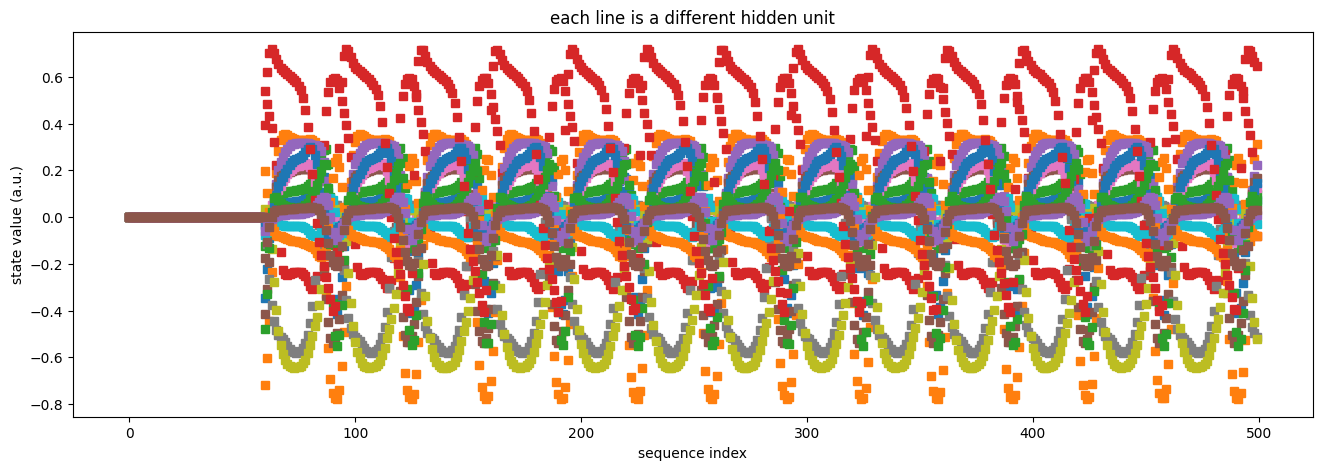

In [154]:
# show the hidden states
plt.figure(figsize=(16,5))

plt.plot(h0,'s')
# plt.plot(h1,'r')
plt.xlabel('sequence index')
plt.ylabel('state value (a.u.)')
plt.title('each line is a different hidden unit')
plt.show()

(200.0, 600.0)

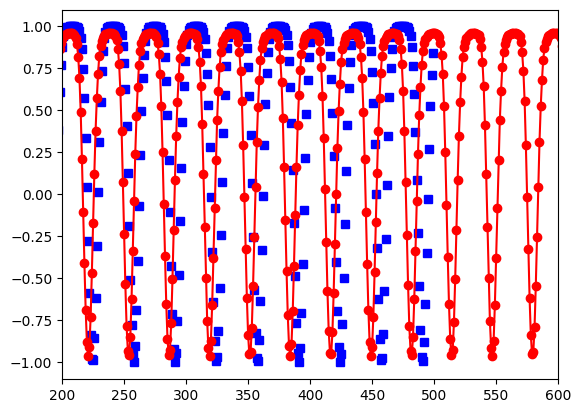

In [162]:
# Longer term extrapolation
# Initialize hidden state
hiddenState = (
    torch.zeros(num_layers, batchsize, num_hidden), # hidden state
    torch.zeros(num_layers, batchsize, num_hidden)  # cell state
)

# Initialize predicted values
yHat = torch.zeros(2*N)
yHat[:N] = data
h0 = np.zeros((N, num_hidden))
h1 = np.zeros((N, num_hidden))

# Loop over time segments
for timei in range(2*N-seqlength):
    
    # grab a snippet of data
    X = yHat[timei:timei+seqlength].view(seqlength, batchsize, input_size)
    
    #forward pass & loss
    yy, hiddenState = trainedModel(X,hiddenState)
    yHat[timei+seqlength] = yy[-1].item()
    hiddenState = (hiddenState[0].detach(), hiddenState[1].detach())

#convert back to np for plotting
yHat = yHat.detach()
#plot
plt.plot(data,'bs' ,label='actual data')
plt.plot(yHat,'ro-' ,label='predicted')
plt.xlim([200,600])
